# COMP90051 Workshop 6
## The Perceptron
***
In this worksheet, we'll implement the perceptron (a building block of neural networks) from scratch. 
Our key objectives are:

* to review the steps involved in the perceptron training algorithm
* to assess how the perceptron behaves in two distinct scenarios (separable vs. non-separable data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.datasets import make_classification

### 1. Synthetic data set
We'll use the built-in `make_classification` function from `sklearn` to generate a synthetic binary classification data set.
The main advantage of using synthetic data is that we have complete control over the distribution. 
This is useful for studying machine learning algorithms under specific conditions.
In particular, we'll be varying the *degree of separability* between the two classes by adjusting the `class_sep` parameter below.
To begin, we'll work with a data set that is almost linearly separable (with `class_sep = 1.75`).

**Note:** In this worksheet we deviate from the standard `0`/`1` encoding for binary class labels used in `sklearn`. 
We use `-1` in place of `0` for the "negative" class to make the mathematical presentation of the perceptron algorithm easier to digest.

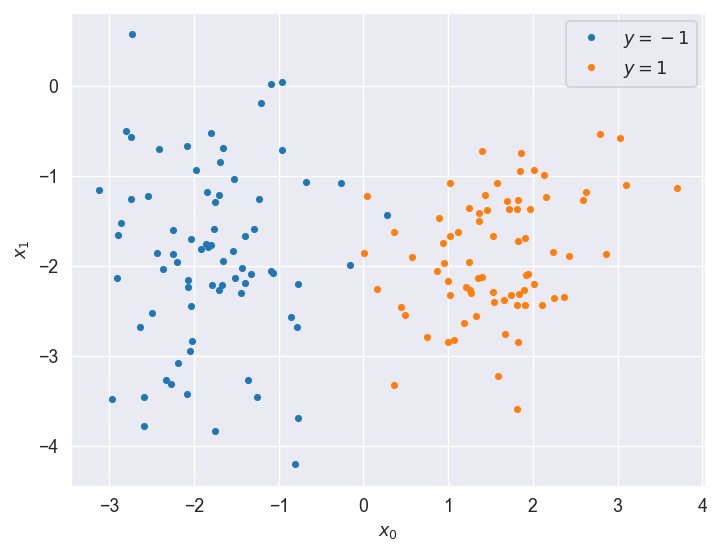

In [2]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

def create_toy_data(n_samples=150, class_sep=1.75):
    X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                               n_redundant=0, n_clusters_per_class=1, flip_y=0,
                               class_sep=class_sep, random_state=12)
    y[y==0] = -1 # encode "negative" class using -1 rather than 0
    plt.plot(X[y==-1,0], X[y==-1,1], ".", label="$y = -1$")
    plt.plot(X[y==1,0], X[y==1,1], ".", label="$y = 1$")
    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()

    return X,y

X, y = create_toy_data(class_sep = 1.75)

**Question:** Is the perceptron a suitable classifier for this data set?

  
In preparation for training and evaluating a perceptron on this data, we randomly partition the data into train/test sets.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 105 instances. Test set has 45 instances.


### 2. Definition of the perceptron

Recall from lectures that a perceptron is a linear binary classifier which maps an input vector $\mathbf{x} \in \mathbb{R}^D$ to a binary output $y \in \{-1,1\}$ given by
$$
\begin{align*}
f(\mathbf{x}; \mathbf{w}, b) &= \begin{cases}
    1 & \mathrm{if} \ s(\mathbf{x}; \mathbf{w}, b) \geq 0, \\
    -1 & \mathrm{otherwise},
\end{cases}
\end{align*}
$$
where $s(\mathbf{x}; \mathbf{w}, b) = \mathbf{w} \cdot \mathbf{x} + b$. 
Here $\mathbf{w} \in \mathbb{R}^D$ is a vector of weights (one for each feature) and $b$ is the bias term. Note that for this worksheet we are including an explicit bias, rather than incorporating it as a constant column in $\mathbf{X}$.

Let start by implementing the weighted sum function $s(\mathbf{x}; \mathbf{w}, b)$ below. This is the 'inner product' $\langle\mathbf{w}, \mathbf{x}\rangle = \sum_i w_i x_i$, which captures the geometrical alignment of the weight and instance vectors. 

In [4]:
def weighted_sum(X, w, b):
    """
    Returns an array containing the weighted sum s(x) for each instance x in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.dot(X, w) + b

def predict(X, w, b):
    """
    Returns an array containing the predicted binary labels (-1/1) for each instance in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    weighted_sums = weighted_sum(X, w, b)
    preds = np.where(weighted_sums >= 0, 1, -1)

    return preds

### 3. Perceptron training algorithm

We will now implement the Perceptron training algorithm first proposed by Rosenblatt in 1957. 

This is an online algorithm in the sense that it examples one point $\mathbf{x}_t$ at a time. At each stage, the algorithm maintains a weight vector $\mathbf{w}_t$ which defines the learned (hyper)plane separating the two classes. For convenience one typically starts with $\mathbf{w}_0 = 0$. The label of the point $\mathbf{x}_t$ is predicted using the sign of the dot product: $\hat{y}_t = \mathrm{sign}(\mathbf{w}_t \cdot \mathbf{x}_t)$. If $\mathbf{x}_t$ is misclassified, $y_t \mathbf{x} \cdot \mathbf{w}_t$ is negative and we make a correction to the weight vector $\mathbf{w}_{t+1} = \mathbf{w}_t + \eta y_t \mathbf{x}_t$ for some learning rate $\eta >0$. To motivate this, consider the dot product of the weight vector after the update with the misclassified instance: 

\begin{align}
y_t (\mathbf{w}_t + \eta y_t \mathbf{x}_t) \cdot \mathbf{x}_t &= y_t \mathbf{w}_t \cdot \mathbf{x}_t + \eta ||\mathbf{x}_t ||^2\\
&\geq y_t \mathbf{w}_t \cdot \mathbf{x}_t
\end{align}

So we reduce the severity of the error by an additive correction $\eta || \mathbf{x}_t ||^2$. We repeat this procedure until convergence or termination after a set limit of iterations. Pseudocode of the algorithm is shown below (taken from _Foundations of Machine Learning, Mohri, 2019_).

<img src="https://i.imgur.com/N6NZrAC.png" alt="Perceptron alg." width="750"/>

**Note:** After iterating through all of the training instances $t=[1, \ldots, T]$, we have completed one *epoch*. The above pseudocode runs for one epoch. Typically, multiple epochs are required to get close to the optimal solution.

The above training procedure is equivalent to performing sequential gradient descent on the following objective function:

\begin{align}
    F(\mathbf{w}) &= \frac{1}{T} \sum_{t=1}^T \max\left(0, -y_t (\mathbf{w} \cdot \mathbf{x}_t)\right) \\
    \mathbf{w}_{t+1} &\leftarrow \mathbf{w}_t - \eta \nabla_{\mathbf{w}} F(\mathbf{w}) 
\end{align}

To motivate the form of $F(\mathbf{w})$, note that if $\mathbf{x}_t$ is misclassified, $-y_t \mathbf{w}_t \cdot \mathbf{x}_t > 0$. In this case the gradient is $\nabla_{\mathbf{w}} F(\mathbf{w}) = -y_t \mathbf{x}_t$, and zero if the instance is correctly classified. Omitting technical details about the case where $\mathbf{w}_t \cdot \mathbf{x}_t = 0$ (we can resolve the non-differentiability by working with _subgradients_), the stochastic online update becomes:

$$ \mathbf{w}_{t+1} \leftarrow
  \begin{cases}
    \mathbf{w}_t + \eta y_t \mathbf{x}_t, & \text{if } y_t\left(\mathbf{x}_t \cdot \mathbf{w}_t\right) \leq 0; \\
    \mathbf{w}_t, & \text{if } y_t\left(\mathbf{x}_t \cdot \mathbf{w}_t\right) > 0 \\
  \end{cases}
$$

***

**Exercise:** Find weights of a perceptron of the following dataset, with learning rate $\eta =0.1$


$$\mathbf{X} = \begin{pmatrix} 1&1&1 \\ 1&1&2 \\ 1&0&0 \\ 1&-1 & 0\end{pmatrix},  \mathbf{y} = \begin{pmatrix} 1 \\ 1 \\ -1 \\ -1 \end{pmatrix}$$

Let's now write a function called `train` which implements sequential gradient descent. The function should implement the pseudocode shown above, repeated for `n_epochs`. 

In [5]:
def train(X, y, w, b, n_epochs=10, eta=0.1):
    """
    Returns updated weight vector w and bias term b for
    the Perceptron algorithm
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    y : numpy array, shape: (n_instances,)
        target class labels relative to X
    n_epochs : int
        number of epochs (full sweeps through X)
    w : numpy array, shape: (n_features,)
        initial guess for weights vector w_0
    b : float
        initial guess for bias term b_0
    eta : positive float
        step size (default: 0.1)
    """
    errors = 0
    for t in range(n_epochs):
        # loop over individual elements in X
        for i in range(X.shape[0]):
            yhat = predict(X[i], w, b)
            if yhat != y[i]:
                errors += 1
                # Update if misclassified, else do nothing
                w += eta * y[i] * X[i] # fill in
                b += eta * y[i] # fill in
                
    print('Number of errors {} / {} iterations'.format(errors, n_epochs * X.shape[0]))
    return w, b

Test your implementation by running it for 5 epochs.
You should get the following result for the weights and bias term:
`w = [ 0.78555827 -0.11419669]; b = 0.1`

In [6]:
# Initialise weights and bias to zero
w = np.zeros(X.shape[1]); b = 0.0

w, b = train(X_train, y_train, w, b, n_epochs=5)
print("w = {}; b = {}".format(w, b))

Number of errors 25 / 525 iterations
w = [ 0.78555827 -0.11419669]; b = 0.1


### 4. Evaluation

Now that we've trained the perceptron, let's see how it performs.

Below we plot the data (training and test sets) along with the decision boundary (which is defined by $\{\mathbf{x}: \hat{\mathbf{w}} \cdot \mathbf{x}= 0$\})
**Note:** It's not necessary to understand how the `plot_results` function works.

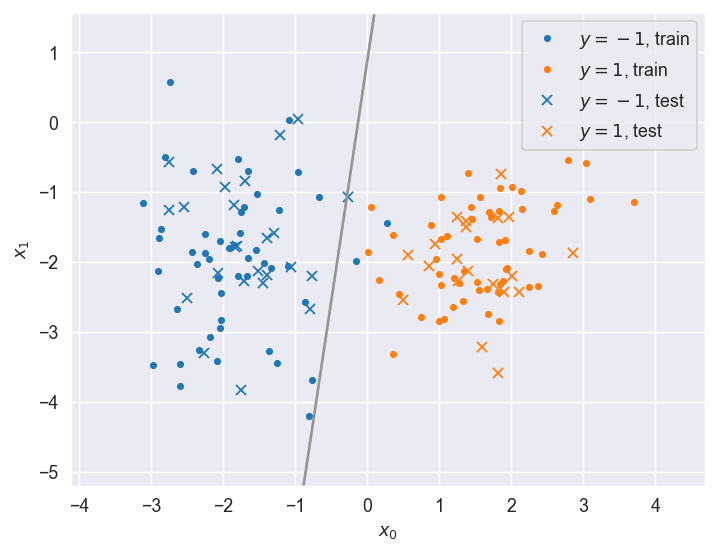

In [7]:
def plot_results(X_train, y_train, X_test, y_test, score_fn, threshold = 0):
    # Plot training set
    plt.plot(X_train[y_train==-1,0], X_train[y_train==-1,1], ".", label=r"$y=-1$, train")
    plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], ".", label=r"$y=1$, train")
    plt.gca().set_prop_cycle(None) # reset colour cycle

    # Plot test set
    plt.plot(X_test[y_test==-1,0], X_test[y_test==-1,1], "x", label=r"$y=-1$, test")
    plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], "x", label=r"$y=1$, test")

    # Compute axes limits
    border = 1
    x0_lower = X[:,0].min() - border
    x0_upper = X[:,0].max() + border
    x1_lower = X[:,1].min() - border
    x1_upper = X[:,1].max() + border

    # Generate grid over feature space
    resolution = 0.01
    x0, x1 = np.mgrid[x0_lower:x0_upper:resolution, x1_lower:x1_upper:resolution]
    grid = np.c_[x0.ravel(), x1.ravel()]
    s = score_fn(grid).reshape(x0.shape)

    # Plot decision boundary (where s(x) == 0)
    plt.contour(x0, x1, s, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)

    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()
    
plot_results(X_train, y_train, X_test, y_test, lambda X: weighted_sum(X, w, b))

**Question:** How well does the decision boundary separate the points in the two classes? How does it perform if you reduce the `class_sep` parameter in the `create_toy_dataset` function above?


To evaluate the perceptron quantitatively, we'll use the error rate (proportion of misclassified instances).
The error rate is a reasonable evaluation measure to use for this data since the classes are well balanced.

Complete the `evaluate` function below.

In [8]:
def evaluate(X, y, w, b):
    """
    Returns the proportion of misclassified instances (error rate)
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    preds = predict(X, w, b)
    misclassified = preds != y
    return sum(misclassified) / y.shape[0] # fill in

print(evaluate(X_train, y_train, w, b))

0.01904761904761905


The code block above computes the error rate on the training data, which is not a good idea in general. (Why?)

Compute the error rate on the test set instead.

In [9]:
print(evaluate(X_test, y_test, w, b))

0.022222222222222223


**Question:** How does this compare to the error on the training set? Is it what you expected?

### 5. Repeat with class overlap
By now you've probably concluded that the perceptron performs well on this data (`class_sep=1.75`), which is to be expected as it's roughly linearly separable. 
However, we know (from lectures) that the perceptron can fail on non-linearly separable data.
To test this scenario, re-generate the synthetic data set with `class_sep=0.5` and repeat Sections 2–4.

**Question:** What do you find? Pay particular attention to the error vs. training epochs (you may need to add a `print` command in the inner training loop). Do you notice anything unusual?

### 6. Reimplement Preceptron in PyTorch

In this last section we will reimplement the Perceptron algorithm in PyTorch.

Armed with this shiny deep learning API, let's rewrite the perceptron training algorithm. We have two options: just using the standard perceptron update formula, or providing torch with the loss function and letting it compute the gradient automatically. We'll go with the latter, a more general solution, which is similar to how you might train a logistic regerssion classification model, regression, counting likelihood etc. In these cases you would change the `loss =` line to reflect the different loss function, e.g., logistic cross entropy, squared error (Gaussian), Poisson loss for the three cases, respectively.

Fill in the code below, and use the [PyTorch API](https://pytorch.org/docs/stable/torch.html#) to understand the operations. Some step are a little cryptic, and relate to enumerating over the training data, setting the shape of the tensors (e.g., `squeeze` which removes redundant dimensions of size 1, `requires_grad_` which flags a parameter for which `backward` will compute the gradient.) Take a look at the [SGD class, and other optimisers](https://pytorch.org/docs/stable/optim.html) and their various parameters.

In [10]:
import torch


def train_perceptron_SGD_pytorch(X, y, n_epochs=30, eta=0.1):
    
    # Create iterable dataset in Torch format
    
    X = torch.cat([torch.ones(X.shape[0],1), X], dim=1)
    train_ds = torch.utils.data.TensorDataset(X, y)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1)
    
    # Create trainable weight vector, tell Torch to track operations on w
    w = torch.zeros(X.shape[1]).double().requires_grad_()
    
    # Set up the optimizer. This implements the basic gradient descent update
    optimizer = torch.optim.SGD([w], lr=eta)
    
    for _ in range(n_epochs):
        for i, (xi,yi) in enumerate(train_loader):
            xi = torch.squeeze(xi)

            #Compute loss F(w)
            loss = torch.max(torch.Tensor([0]), -yi * (torch.dot(w,xi)))
            
            # Backpropagation and update
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients using backpropagation
            optimizer.step()  # Update weights using the optimizer
            
        
    w = w.detach()  # Tell Torch to stop tracking operations for autograd
    print('Trained weights:', w)
    return w.numpy()

Now run the function above to verify it reaches a similar solution to the `numpy` code above. 

Trained weights: tensor([ 0.1500,  0.5651, -0.0613], dtype=torch.float64)


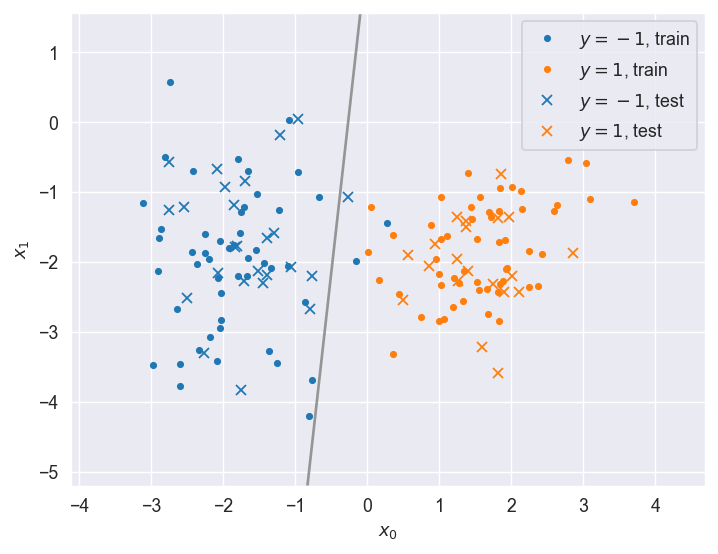

In [12]:
w = train_perceptron_SGD_pytorch(torch.from_numpy(X_train), torch.from_numpy(y_train),n_epochs = 5)

plot_results(X_train, y_train, X_test, y_test, score_fn=lambda x: np.dot(x,w[1:])+w[0])

## Bonus tasks (optional)

### Comparison with logistic regression
We've seen that the perceptron is not robust to binary classification problems with overlapping classes. 
But how does logistic regression fare in this case?

Adapt the code block above to fit a logistic regression model. To do so you will need to change the loss function to the cross entropy loss from the logistic regression model. 